Used the following Kaggle aticle for reference: https://www.kaggle.com/code/ekaterinadranitsyna/segformer-water-segmentation-pytorch

DATASET STRUCTURE:

google drive folders:

  -input_png: 400 images representing mangrove extent (RGB)

  -output_png: 400 images representing mangrove extent change (RGB)

TASK:

finetuning NVIDIA's segforme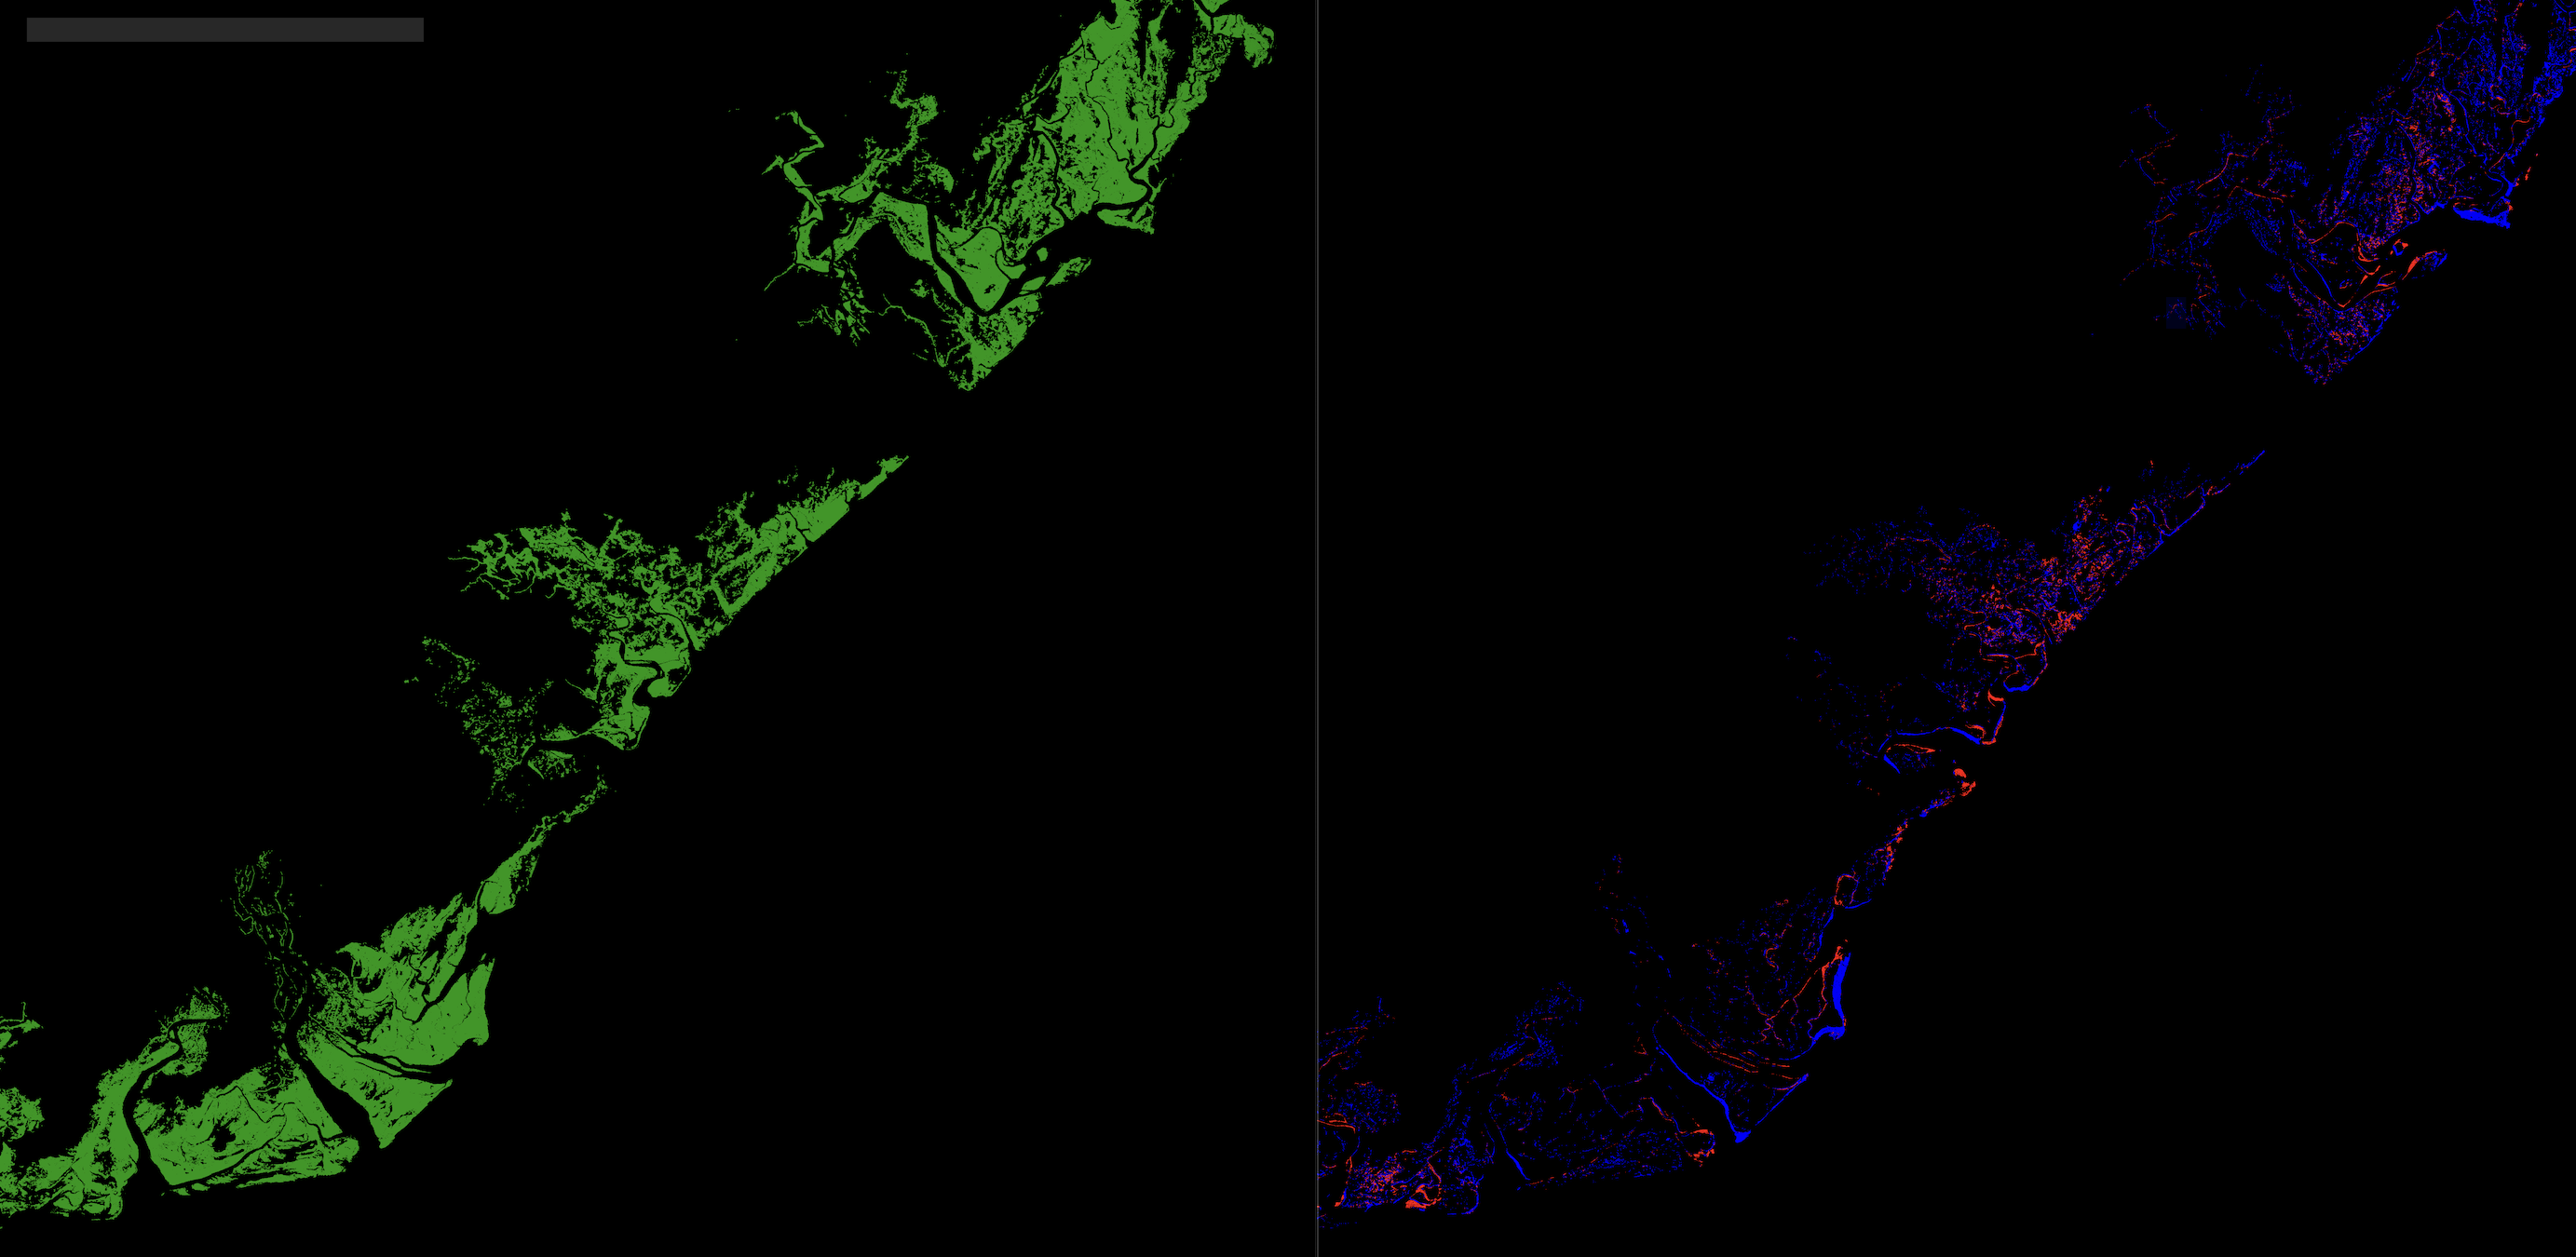r for multiclass segmentation



In [41]:
!pip install -q evaluate transformers[torch]

In [42]:
!pip install -q datasets
from datasets import load_dataset

In [43]:
import cv2
import tifffile
from pathlib import Path
import shutil
import concurrent.futures
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
from transformers import (
    SegformerForSemanticSegmentation,
    TrainingArguments, Trainer,
    SegformerImageProcessor)
from datasets import Dataset, Image
import evaluate
import matplotlib.pyplot as plt

In [112]:
from PIL import Image
import numpy as np
from datasets import load_dataset

# Assuming 'dataset' is your loaded dataset
dataset = load_dataset("pruhtopia/mangrove-loss-dataset")

In [120]:
from PIL import ImageStat, Image

def is_image_black(image1, image2):
    """
    Check if two given PIL images are completely black.
    """
    stat1 = ImageStat.Stat(image1)
    stat2 = ImageStat.Stat(image2)
    # Check if all channels in both images have a sum of 0 (completely black)
    return all(x == 0 for x in stat1.sum) or all(x == 0 for x in stat2.sum)

def filter_black_images(example):
    """
    Returns False if both images in the example are completely black, True otherwise.
    Assumes 'image1' and 'image2' are keys in the example pointing to PIL images.
    """
    image1 = example['pixel_values']
    image2 = example['label']
    # Use the is_image_black function to check the images
    return not is_image_black(image1, image2)

# Apply the filtering
filtered_dataset = dataset.filter(lambda example: filter_black_images(example))

#apply code to convert each of the 'label' image in each row in filtered_dataset is converted to 0s and 1s and instead of 0s and 255s
def convert_labels_to_binary(example):
    """
    Converts a label image with pixel values of 0 and 255 to a binary format (0 and 1).
    Assumes 'label' is a key in the example pointing to a PIL image.
    """
    label_img = example['label']
    label_array = np.array(label_img)

    # Convert pixel values: 255 to 1, keep 0s as is
    label_array[label_array == 255] = 1

    # Convert back to PIL Image
    example['label'] = Image.fromarray(label_array.astype(np.uint8))
    print(np.unique(np.array(example['label'])))
    return example

# Apply the conversion to the filtered dataset
#filtered_dataset = filtered_dataset.map(convert_labels_to_binary)

dataset = filtered_dataset

In [62]:
# Split the dataset into training and validation sets with a 10% split for validation
split_dataset = dataset["train"].train_test_split(test_size=0.1, shuffle=False)

# Extract the training and validation datasets
ds_train = split_dataset["train"]
ds_valid = split_dataset["test"]

print(f"Training Set Size: {len(ds_train)}")
print(f"Validation Set Size: {len(ds_valid)}")

Training Set Size: 356
Validation Set Size: 40


In [63]:
plt.rcParams['figure.figsize'] = 12, 12

In [64]:
MODEL_CHECKPOINT = 'nvidia/mit-b0'

VAL_SIZE = 0.1
BATCH_SIZE = 4
EPOCHS = 3
LR = 0.00006

IMG_SIZE = 512

In [65]:
# Image preprocessing native to the pretrained model.
feature_extractor = SegformerImageProcessor.from_pretrained(MODEL_CHECKPOINT)

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:102: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [66]:
def apply_transforms(batch):
    images = [x for x in batch['pixel_values']]
    labels = [x for x in batch['label']]
    inputs = feature_extractor(images, labels)
    return inputs


ds_train.set_transform(apply_transforms)
ds_valid.set_transform(apply_transforms)

In [67]:
id2label = {0: 'background', 1: 'loss'}
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)

model = SegformerForSemanticSegmentation.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

num_labels

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2

In [84]:
metric = evaluate.load('mean_iou')
class_weights = [1, 20]

def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        # scale the logits to the size of the label
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode='bilinear',
            align_corners=False,
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()
        # currently using _compute instead of compute
        # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
        metrics = metric._compute(
                predictions=pred_labels,
                references=labels,
                num_labels=len(id2label),
                ignore_index=0,
                reduce_labels=feature_extractor.do_reduce_labels,
            )

        # add per category metrics as individual key-value pairs
        per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
        per_category_iou = metrics.pop("per_category_iou").tolist()

        metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
        metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

        return metrics

In [85]:
training_args = TrainingArguments(
    'segformer-finetuned-mangrove',
    learning_rate=LR,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    save_total_limit=3,
    evaluation_strategy='steps',
    save_strategy='steps',
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    push_to_hub=True,
    hub_model_id='pruhtopia/segformer-finetuned-mangrove',
    hub_strategy="end",
)

In [86]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_valid,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Accuracy Background,Accuracy Loss,Iou Background,Iou Loss,Runtime,Samples Per Second,Steps Per Second
20,0.011800,0.006276,0.000000,0.000000,0.000000,nan,0.000000,0.000000,0.000000,1.859400,21.513000,5.378000
40,0.008800,0.006027,0.000000,0.000000,0.000000,nan,0.000000,0.000000,0.000000,1.805800,22.151000,5.538000
60,0.013000,0.005716,0.000000,0.000000,0.000000,nan,0.000000,0.000000,0.000000,1.826500,21.900000,5.475000
80,0.006000,0.005933,0.000000,0.000000,0.000000,nan,0.000000,0.000000,0.000000,1.963000,20.377000,5.094000
100,0.003600,0.005559,0.000000,0.000000,0.000000,nan,0.000000,0.000000,0.000000,1.808700,22.115000,5.529000
120,0.006800,0.005740,0.000000,0.000000,0.000000,nan,0.000000,0.000000,0.000000,2.627100,15.226000,3.806000
140,0.003900,0.006055,0.000000,0.000000,0.000000,nan,0.000000,0.000000,0.000000,1.792500,22.315000,5.579000
160,0.005900,0.005879,0.000000,0.000000,0.000000,nan,0.000000,0.000000,0.000000,1.798300,22.243000,5.561000
180,0.010200,0.005263,0.000000,0.000000,0.000000,nan,0.000000,0.000000,0.000000,1.829300,21.866000,5.467000
200,0.005500,0.005276,0.000000,0.000000,0.000000,nan,0.000000,0.000000,0.000000,1.815200,22.036000,5.509000


/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encoun

TrainOutput(global_step=267, training_loss=0.007788927864618181, metrics={'train_runtime': 93.0587, 'train_samples_per_second': 11.477, 'train_steps_per_second': 2.869, 'total_flos': 1.871985649700045e+16, 'train_loss': 0.007788927864618181, 'epoch': 3.0})

In [ ]:
import cv2
import os
import numpy as np

# Input and output folder paths
input_folder = "/content/drive/MyDrive/IBM_Spring24/mangrove_dataset/output_png"
output_folder = "/content/drive/MyDrive/IBM_Spring24/mangrove_dataset/output_png_mask"

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

def create_binary_mask(input_image_path, output_image_path):
    # Load the image
    image = cv2.imread(input_image_path)

    # Extract the red channel
    red_channel = image[:, :, 2]  # Assuming RGB channels

    # Thresholding: Pixels with red value > 0 will be set to 1, otherwise 0
    binary_mask = np.where(red_channel > 0, 255, 0).astype(np.uint8)  # Scale to 0-255 and convert to uint8

    # Save the binary mask as a PNG file
    cv2.imwrite(output_image_path, binary_mask)

# Iterate through the images in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(".png"):  # Assuming all files in the folder are PNG images
        input_image_path = os.path.join(input_folder, filename)
        output_image_path = os.path.join(output_folder, filename)

        # Create the binary mask for the current image
        create_binary_mask(input_image_path, output_image_path)

print("Binary masks creation complete.")


Binary masks creation complete.


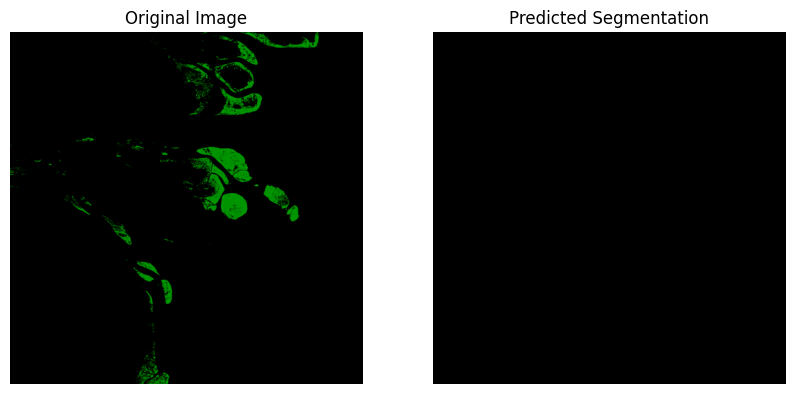

[0]


In [125]:
# Define the path to your image
image_path = "/content/GMW_S08E143_1996_v3.png"

# Load the image
image = Image.open(image_path).convert("RGB")

# Preprocess the image using the feature extractor
inputs = feature_extractor(images=image, return_tensors="pt")

# Move inputs to the same device as the model
inputs = {k: v.to(model.device) for k, v in inputs.items()}

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)

# Process the outputs as needed (e.g., extracting specific data from the model's output)
# For example, if it's a segmentation model, you might want to get the predicted masks
predictions = torch.argmax(outputs.logits, dim=1).squeeze().cpu().numpy()

# Convert 1s to 255s for visibility
predictions_visible = np.where(predictions==1, 255, 0)

# Visualization
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

# Predicted Segmentation in Visible Format
plt.subplot(1, 2, 2)
plt.imshow(predictions_visible, cmap='gray')  # Use gray colormap for clearer visualization
plt.title('Predicted Segmentation')
plt.axis('off')

plt.show()